## Titanic Project

**1. 목표**
 - 머신러닝 알고리즘을 활용하여 타이타닉 해상사고에서 살아남은 승객 예측
 - Target column : Survived column

**2. 데이터 셋**
 - 승객의 이름(Name), 나이(Age), 성별(Sex), 티켓(Ticket), 생존여부(Survived) 등 891 X 12 shape 데이터
 - 결측치처리 : Age는 성별(Sex), 탑승클래스(Pclass), 생존여부 등을 참고하여 Median 값으로 대체, 결측치가 약 77%인 Cabin 컬럼은 삭제, Embarked 컬럼은 결측치 행 2개 삭제
 - 피쳐엔지니어링 : Age는 10살 단위, Fare는 $20 단위의 범주형 피쳐 생성(Age_range, Fare_range), SibSp와 Parch의 값을 더한 SibSp_Parch 피쳐생성 
 - Survived class(생존자/사망자)의 불균형을 해소하기 위해 Up-Sampling

**3. 모델링/평가방법**
 - 알고리즘 : DecisionTree, RandomForest, LogisticRegression, Catboost
 - 평가방법 : Accuracy
 
**4. 예측결과**
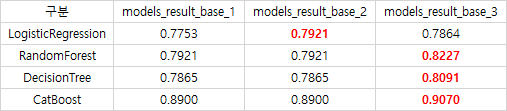


In [328]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score , confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTENC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

### Titanic 데이터 읽기 및 탐색

In [329]:
df = pd.read_csv("./data/titanic.csv", encoding="utf-8")

In [330]:
df.shape

(891, 12)

In [331]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [332]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [333]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

< PassengerId column type is int64. >
PassengerId has 891 class 


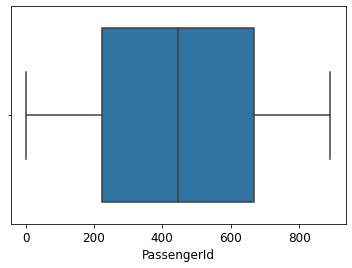




< Survived column type is int64. >
Survived has 2 class 


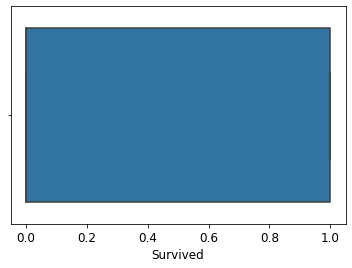




< Pclass column type is int64. >
Pclass has 3 class 


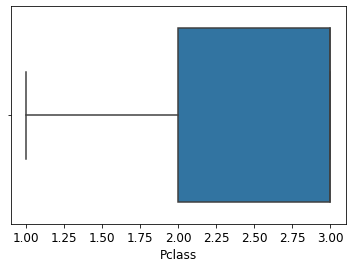




< Name column type is object. >
Name has 891 class 
Brewe, Dr. Arthur Jackson                            1
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)    1
Stahelin-Maeglin, Dr. Max                            1
Sjoblom, Miss. Anna Sofia                            1
Bishop, Mrs. Dickinson H (Helen Walton)              1
                                                    ..
Lennon, Mr. Denis                                    1
Goldsmith, Mr. Frank John                            1
Pears, Mr. Thomas Clinton                            1
Doling, Mrs. John T (Ada Julia Bone)                 1
Longley, Miss. Gretchen Fiske                        1
Name: Name, Length: 891, dtype: int64



< Sex column type is object. >
Sex has 2 class 
male      577
female    314
Name: Sex, dtype: int64


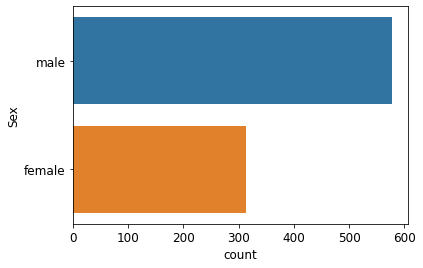




< Age column type is float64. >
Age has 88 class 


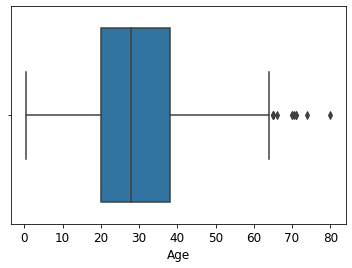




< SibSp column type is int64. >
SibSp has 7 class 


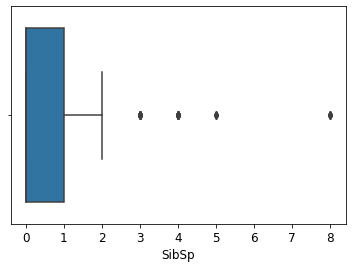




< Parch column type is int64. >
Parch has 7 class 


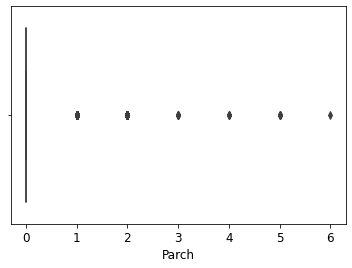




< Ticket column type is object. >
Ticket has 681 class 
CA. 2343    7
347082      7
1601        7
CA 2144     6
347088      6
           ..
PC 17474    1
244270      1
349203      1
113788      1
248723      1
Name: Ticket, Length: 681, dtype: int64



< Fare column type is float64. >
Fare has 248 class 


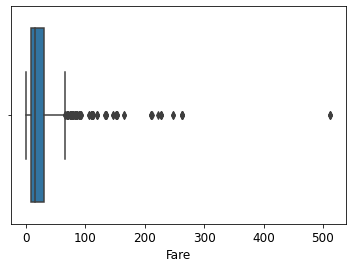




< Cabin column type is object. >
Cabin has 147 class 
C23 C25 C27    4
B96 B98        4
G6             4
F33            3
E101           3
              ..
C148           1
C82            1
C90            1
E36            1
B78            1
Name: Cabin, Length: 147, dtype: int64



< Embarked column type is object. >
Embarked has 3 class 
S    644
C    168
Q     77
Name: Embarked, dtype: int64


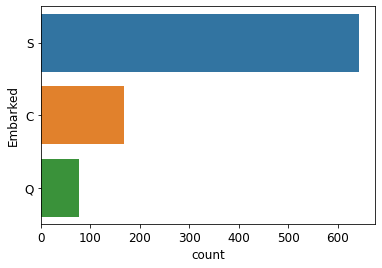

In [334]:
for columns_call in df.columns:
    
    class_num = int(df[columns_call].value_counts().count())
    
    print("< {} column type is {}. >".format(columns_call, df[columns_call].dtype))    
    print("{} has {} class ".format(columns_call, class_num))
    
    
    if df[columns_call].dtype == "object":
        
        if class_num < 20:            
        
            print(df[columns_call].value_counts())
            sns.countplot(y=columns_call, data=df)
            plt.show()
        
        else :
            
            print(df[columns_call].value_counts())
        
        
    else :
        
        sns.boxplot(x=df[columns_call])
        plt.show()
        
    print("\n\n")
        

### Parch, SibSp, Survived, Pclass 피쳐를 범주형 피쳐로 변경

In [335]:
df["Parch"] = df["Parch"].astype(object)
df["SibSp"] = df["SibSp"].astype(object)
df["Survived"] = df["Survived"].astype(object)
df["Pclass"] = df["Pclass"].astype(object)

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


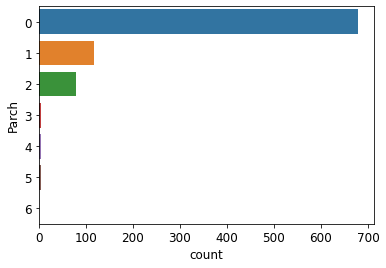

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


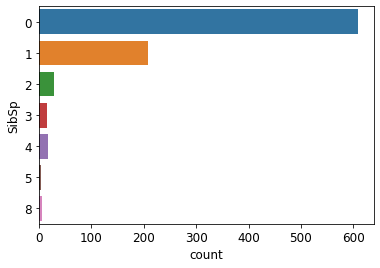

Survived
0    549
1    342
Name: Survived, dtype: int64


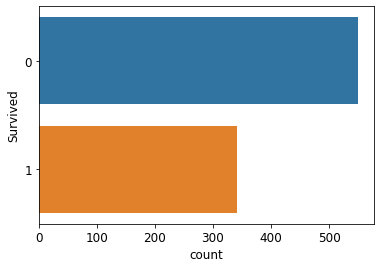

Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64


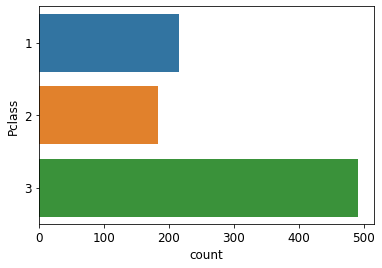

In [336]:
new_obj_cols = ["Parch", "SibSp", "Survived", "Pclass"]

for col in new_obj_cols:
    
    print(col)
    print(df[col].value_counts())
    sns.countplot(y=col, data=df)
    plt.show()

### Titanic 생존자 예측모델링(Base1)

In [337]:
df_base1 = df.copy()

In [338]:
df_base1.select_dtypes(include=[object]).describe()

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked
count,891,891,891,891,891,891,891,204,889
unique,2,3,891,2,7,7,681,147,3
top,0,3,"Brewe, Dr. Arthur Jackson",male,0,0,CA. 2343,C23 C25 C27,S
freq,549,491,1,577,608,678,7,4,644


In [339]:
df_base1.select_dtypes(include=[np.number]).describe()

,PassengerId,Age,Fare
count,891.000000,714.000000,891.000000
mean,446.000000,29.699118,32.204208
std,257.353842,14.526497,49.693429
min,1.000000,0.420000,0.000000
25%,223.500000,20.125000,7.910400
50%,446.000000,28.000000,14.454200
75%,668.500000,38.000000,31.000000
max,891.000000,80.000000,512.329200


### Age, Cabin, Embarked결측치 처리 & 의미없는 피쳐 삭제

In [340]:
del df_base1["Name"]
del df_base1["PassengerId"]

In [341]:
df_base1.isnull().sum() / len(df_base1) *100

Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [342]:
del df_base1['Cabin']
df_base1.loc[df_base1["Age"].isnull() , "Age"] = df_base1[df_base1["Age"].notnull()]["Age"].mean()

In [343]:
df_base1[df_base1['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,female,38.0,0,0,113572,80.0,NaN
829,1,1,female,62.0,0,0,113572,80.0,NaN


In [344]:
idx_em_nan = list(df_base1[df_base1['Embarked'].isnull()].index)

In [345]:
df_base1 = df_base1.drop(idx_em_nan)

In [346]:
df_base1.shape

(889, 9)

In [347]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [348]:
df_base1['Ticket'].value_counts()

347082      7
1601        7
CA. 2343    7
347088      6
CA 2144     6
           ..
PC 17474    1
244270      1
349203      1
113788      1
248723      1
Name: Ticket, Length: 680, dtype: int64

In [349]:
del df_base1['Ticket']

In [350]:
df_base1.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [351]:
df_base1.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [352]:
train_data = df_base1.drop(columns=["Survived"])
target_data = df_base1["Survived"].astype(int)

### 범주형 피쳐의 라벨인코딩

In [353]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [354]:
for col in train_data.columns.tolist():
    if train_data[col].dtype =="object":
        encoder = LabelEncoder()
        encoder.fit(train_data[col])
        train_data[col] = encoder.fit_transform(train_data[col])

In [355]:
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,22.0,1,0,7.2500,2
1,0,0,38.0,1,0,71.2833,0
2,2,0,26.0,0,0,7.9250,2
3,0,0,35.0,1,0,53.1000,2
4,2,1,35.0,0,0,8.0500,2


### 훈련/검증 데이터셋 구분

In [356]:
x_train , x_test , y_train , y_test = train_test_split(train_data ,
                                                      target_data, 
                                                      test_size=0.2, 
                                                      random_state=2020)

### 모델링(Logistic Regression, RandomForest, DecisionTree)

In [357]:
lr_clf = LogisticRegression(random_state=2020)
rf_clf = RandomForestClassifier(random_state=2020)
dt_clf = DecisionTreeClassifier(random_state=2020)

In [358]:
models = [[lr_clf,"LogisticRegression"], [rf_clf,"RandomForestClassifier"], [dt_clf,"DecisionTreeClassifier"]]

In [359]:
models_result_base_1 = {}

LogisticRegression
교차 검증 0 정확도 0.8601
교차 검증 1 정확도 0.7676
교차 검증 2 정확도 0.8592
교차 검증 3 정확도 0.7324
교차 검증 4 정확도 0.7676
훈련평균정확도 0.7974
예측 정확도 : 0.7753
 < Confusion Matrix > 
 [[86 18]
 [22 52]]


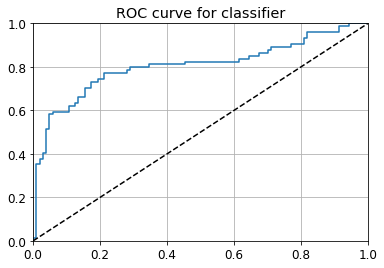



RandomForestClassifier
교차 검증 0 정확도 0.8741
교차 검증 1 정확도 0.7746
교차 검증 2 정확도 0.8732
교차 검증 3 정확도 0.7113
교차 검증 4 정확도 0.8099
훈련평균정확도 0.8086
예측 정확도 : 0.7921
 < Confusion Matrix > 
 [[89 15]
 [22 52]]


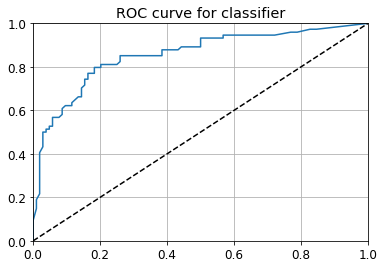



DecisionTreeClassifier
교차 검증 0 정확도 0.8322
교차 검증 1 정확도 0.7324
교차 검증 2 정확도 0.8732
교차 검증 3 정확도 0.6761
교차 검증 4 정확도 0.7254
훈련평균정확도 0.7678
예측 정확도 : 0.7865
 < Confusion Matrix > 
 [[87 17]
 [21 53]]


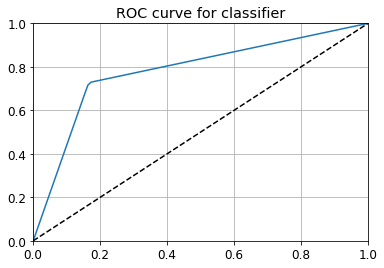

In [360]:
for tr_models, model_name in models:
    
    print(model_name)
    
    tr_models.fit(x_train, y_train)
    
    scores = cross_val_score(tr_models, x_train, y_train, cv=5)
    
    models_pred = tr_models.predict(x_test)
        
    for iter_count , accuracy in enumerate(scores):
        print("교차 검증 {} 정확도 {:.4f}".format(iter_count , accuracy))
    print("훈련평균정확도 {:.4f}".format(np.mean(scores)))
    
    preds = tr_models.predict(x_test)
    acc = accuracy_score(y_test , preds)
    
    print("예측 정확도 : {:.4f}".format(acc))
    print(" < Confusion Matrix > \n {}".format(confusion_matrix(y_test , preds)))
    
    preds_prob = tr_models.predict_proba(x_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, preds_prob[:,1])

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for classifier')
    # plt.xlabel('False Positive Rate (1 - Specificity)')
    # plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()
    
    print("\n")    
    
    # 결과 요약표를 만들기 위해 Dict 형태로 저장
    tr_models_train = str(model_name) +'_Train'
    tr_models_test = str(model_name) +'_test'
    models_result_base_1[tr_models_train] = round(np.mean(scores),4)
    models_result_base_1[tr_models_test] = round(acc, 4)
    

### 모델링(Catboost)

In [361]:
train_data = df_base1.drop(columns=["Survived"])
target_data = df_base1["Survived"].astype(int)

In [362]:
x_train , x_test , y_train , y_test = train_test_split(train_data ,
                                                      target_data, 
                                                      test_size=0.2, 
                                                      random_state=2020)

In [363]:
object_col_index = []
for index , col in enumerate(x_train.columns.tolist()):
    if x_train[col].dtype =="object":
        object_col_index.append(index)

In [364]:
object_col_index

[0, 1, 3, 4, 6]

In [365]:
cat_model = CatBoostClassifier(iterations =2020 , 
                          learning_rate = 0.003,
                          depth = 4,
                          l2_leaf_reg = 3,
                          loss_function ="Logloss")

In [366]:
cat_model.fit(x_train , y_train, cat_features=object_col_index)

0:	learn: 0.6919227	total: 6.37ms	remaining: 12.9s
1:	learn: 0.6900516	total: 13.9ms	remaining: 14s
2:	learn: 0.6882233	total: 26.3ms	remaining: 17.7s
3:	learn: 0.6863433	total: 27.6ms	remaining: 13.9s
4:	learn: 0.6843864	total: 32.2ms	remaining: 13s
5:	learn: 0.6827129	total: 33.2ms	remaining: 11.2s
6:	learn: 0.6811800	total: 34.1ms	remaining: 9.8s
7:	learn: 0.6794275	total: 43.6ms	remaining: 11s
8:	learn: 0.6782731	total: 44.4ms	remaining: 9.92s
9:	learn: 0.6763463	total: 48.8ms	remaining: 9.81s
10:	learn: 0.6746419	total: 50.3ms	remaining: 9.18s
11:	learn: 0.6728944	total: 51.9ms	remaining: 8.69s
12:	learn: 0.6711606	total: 53.9ms	remaining: 8.33s
13:	learn: 0.6694813	total: 55.1ms	remaining: 7.9s
14:	learn: 0.6677658	total: 59.7ms	remaining: 7.99s
15:	learn: 0.6660843	total: 61.3ms	remaining: 7.67s
16:	learn: 0.6646401	total: 63ms	remaining: 7.42s
17:	learn: 0.6629420	total: 67.4ms	remaining: 7.5s
18:	learn: 0.6613072	total: 68.8ms	remaining: 7.25s
19:	learn: 0.6596934	total: 71.2m

191:	learn: 0.4954825	total: 518ms	remaining: 4.93s
192:	learn: 0.4949849	total: 523ms	remaining: 4.95s
193:	learn: 0.4945063	total: 528ms	remaining: 4.97s
194:	learn: 0.4941054	total: 535ms	remaining: 5s
195:	learn: 0.4936186	total: 539ms	remaining: 5.01s
196:	learn: 0.4929200	total: 546ms	remaining: 5.05s
197:	learn: 0.4925256	total: 553ms	remaining: 5.09s
198:	learn: 0.4918943	total: 554ms	remaining: 5.07s
199:	learn: 0.4915592	total: 559ms	remaining: 5.09s
200:	learn: 0.4912845	total: 560ms	remaining: 5.07s
201:	learn: 0.4905957	total: 568ms	remaining: 5.11s
202:	learn: 0.4900438	total: 569ms	remaining: 5.09s
203:	learn: 0.4896261	total: 570ms	remaining: 5.07s
204:	learn: 0.4890295	total: 571ms	remaining: 5.05s
205:	learn: 0.4885291	total: 573ms	remaining: 5.04s
206:	learn: 0.4880951	total: 574ms	remaining: 5.03s
207:	learn: 0.4878341	total: 574ms	remaining: 5s
208:	learn: 0.4872185	total: 576ms	remaining: 4.99s
209:	learn: 0.4867795	total: 580ms	remaining: 4.99s
210:	learn: 0.4862

375:	learn: 0.4351839	total: 1.22s	remaining: 5.33s
376:	learn: 0.4350491	total: 1.22s	remaining: 5.33s
377:	learn: 0.4348642	total: 1.23s	remaining: 5.32s
378:	learn: 0.4346616	total: 1.23s	remaining: 5.33s
379:	learn: 0.4344645	total: 1.23s	remaining: 5.33s
380:	learn: 0.4341792	total: 1.24s	remaining: 5.32s
381:	learn: 0.4339230	total: 1.24s	remaining: 5.33s
382:	learn: 0.4337814	total: 1.25s	remaining: 5.35s
383:	learn: 0.4336364	total: 1.26s	remaining: 5.35s
384:	learn: 0.4335376	total: 1.26s	remaining: 5.34s
385:	learn: 0.4333196	total: 1.26s	remaining: 5.33s
386:	learn: 0.4330452	total: 1.26s	remaining: 5.34s
387:	learn: 0.4328619	total: 1.27s	remaining: 5.37s
388:	learn: 0.4326871	total: 1.28s	remaining: 5.36s
389:	learn: 0.4326673	total: 1.28s	remaining: 5.34s
390:	learn: 0.4324569	total: 1.28s	remaining: 5.33s
391:	learn: 0.4321777	total: 1.28s	remaining: 5.34s
392:	learn: 0.4319170	total: 1.29s	remaining: 5.34s
393:	learn: 0.4317858	total: 1.29s	remaining: 5.34s
394:	learn: 

538:	learn: 0.4117128	total: 1.92s	remaining: 5.27s
539:	learn: 0.4116609	total: 1.92s	remaining: 5.26s
540:	learn: 0.4116359	total: 1.92s	remaining: 5.26s
541:	learn: 0.4115486	total: 1.93s	remaining: 5.26s
542:	learn: 0.4114516	total: 1.94s	remaining: 5.27s
543:	learn: 0.4112798	total: 1.94s	remaining: 5.27s
544:	learn: 0.4111814	total: 1.95s	remaining: 5.29s
545:	learn: 0.4109681	total: 1.96s	remaining: 5.3s
546:	learn: 0.4109267	total: 1.97s	remaining: 5.3s
547:	learn: 0.4108442	total: 1.97s	remaining: 5.29s
548:	learn: 0.4107801	total: 1.98s	remaining: 5.29s
549:	learn: 0.4106519	total: 1.98s	remaining: 5.29s
550:	learn: 0.4106209	total: 1.98s	remaining: 5.28s
551:	learn: 0.4105814	total: 1.98s	remaining: 5.27s
552:	learn: 0.4105287	total: 1.98s	remaining: 5.26s
553:	learn: 0.4104784	total: 1.99s	remaining: 5.26s
554:	learn: 0.4103941	total: 1.99s	remaining: 5.25s
555:	learn: 0.4103177	total: 2s	remaining: 5.26s
556:	learn: 0.4102160	total: 2s	remaining: 5.26s
557:	learn: 0.410179

707:	learn: 0.3968643	total: 2.79s	remaining: 5.18s
708:	learn: 0.3967925	total: 2.8s	remaining: 5.17s
709:	learn: 0.3967236	total: 2.8s	remaining: 5.17s
710:	learn: 0.3966968	total: 2.8s	remaining: 5.16s
711:	learn: 0.3966517	total: 2.81s	remaining: 5.17s
712:	learn: 0.3965695	total: 2.83s	remaining: 5.18s
713:	learn: 0.3965460	total: 2.83s	remaining: 5.18s
714:	learn: 0.3964129	total: 2.83s	remaining: 5.17s
715:	learn: 0.3962676	total: 2.83s	remaining: 5.16s
716:	learn: 0.3962500	total: 2.84s	remaining: 5.16s
717:	learn: 0.3961555	total: 2.84s	remaining: 5.16s
718:	learn: 0.3961452	total: 2.85s	remaining: 5.15s
719:	learn: 0.3960764	total: 2.85s	remaining: 5.14s
720:	learn: 0.3959718	total: 2.85s	remaining: 5.13s
721:	learn: 0.3959026	total: 2.85s	remaining: 5.12s
722:	learn: 0.3957794	total: 2.86s	remaining: 5.13s
723:	learn: 0.3957286	total: 2.86s	remaining: 5.12s
724:	learn: 0.3957015	total: 2.87s	remaining: 5.12s
725:	learn: 0.3956145	total: 2.87s	remaining: 5.12s
726:	learn: 0.3

872:	learn: 0.3881480	total: 3.49s	remaining: 4.58s
873:	learn: 0.3880929	total: 3.49s	remaining: 4.58s
874:	learn: 0.3880429	total: 3.49s	remaining: 4.57s
875:	learn: 0.3879959	total: 3.5s	remaining: 4.57s
876:	learn: 0.3879851	total: 3.5s	remaining: 4.56s
877:	learn: 0.3879171	total: 3.5s	remaining: 4.56s
878:	learn: 0.3878824	total: 3.51s	remaining: 4.55s
879:	learn: 0.3878080	total: 3.51s	remaining: 4.55s
880:	learn: 0.3877905	total: 3.51s	remaining: 4.54s
881:	learn: 0.3877636	total: 3.52s	remaining: 4.54s
882:	learn: 0.3877045	total: 3.52s	remaining: 4.53s
883:	learn: 0.3876299	total: 3.53s	remaining: 4.54s
884:	learn: 0.3875727	total: 3.54s	remaining: 4.54s
885:	learn: 0.3875203	total: 3.55s	remaining: 4.54s
886:	learn: 0.3874716	total: 3.56s	remaining: 4.54s
887:	learn: 0.3874706	total: 3.56s	remaining: 4.53s
888:	learn: 0.3874410	total: 3.56s	remaining: 4.53s
889:	learn: 0.3873463	total: 3.56s	remaining: 4.53s
890:	learn: 0.3873298	total: 3.57s	remaining: 4.52s
891:	learn: 0.3

1042:	learn: 0.3813106	total: 4.2s	remaining: 3.94s
1043:	learn: 0.3812891	total: 4.2s	remaining: 3.93s
1044:	learn: 0.3812678	total: 4.21s	remaining: 3.92s
1045:	learn: 0.3812532	total: 4.21s	remaining: 3.92s
1046:	learn: 0.3811985	total: 4.21s	remaining: 3.92s
1047:	learn: 0.3811614	total: 4.22s	remaining: 3.91s
1048:	learn: 0.3810995	total: 4.22s	remaining: 3.91s
1049:	learn: 0.3810742	total: 4.23s	remaining: 3.91s
1050:	learn: 0.3810183	total: 4.24s	remaining: 3.91s
1051:	learn: 0.3809577	total: 4.25s	remaining: 3.91s
1052:	learn: 0.3809276	total: 4.25s	remaining: 3.91s
1053:	learn: 0.3809187	total: 4.26s	remaining: 3.9s
1054:	learn: 0.3808505	total: 4.27s	remaining: 3.9s
1055:	learn: 0.3808283	total: 4.28s	remaining: 3.9s
1056:	learn: 0.3808118	total: 4.28s	remaining: 3.9s
1057:	learn: 0.3807921	total: 4.28s	remaining: 3.89s
1058:	learn: 0.3807169	total: 4.3s	remaining: 3.9s
1059:	learn: 0.3807126	total: 4.3s	remaining: 3.89s
1060:	learn: 0.3806636	total: 4.3s	remaining: 3.89s
106

1219:	learn: 0.3749675	total: 5.08s	remaining: 3.33s
1220:	learn: 0.3749284	total: 5.09s	remaining: 3.33s
1221:	learn: 0.3748840	total: 5.09s	remaining: 3.33s
1222:	learn: 0.3748382	total: 5.1s	remaining: 3.33s
1223:	learn: 0.3748061	total: 5.11s	remaining: 3.32s
1224:	learn: 0.3747917	total: 5.11s	remaining: 3.32s
1225:	learn: 0.3747599	total: 5.13s	remaining: 3.32s
1226:	learn: 0.3747094	total: 5.13s	remaining: 3.32s
1227:	learn: 0.3746687	total: 5.14s	remaining: 3.32s
1228:	learn: 0.3746176	total: 5.15s	remaining: 3.32s
1229:	learn: 0.3745765	total: 5.16s	remaining: 3.32s
1230:	learn: 0.3745583	total: 5.17s	remaining: 3.32s
1231:	learn: 0.3745085	total: 5.18s	remaining: 3.31s
1232:	learn: 0.3745044	total: 5.19s	remaining: 3.31s
1233:	learn: 0.3744931	total: 5.19s	remaining: 3.31s
1234:	learn: 0.3744666	total: 5.2s	remaining: 3.31s
1235:	learn: 0.3744144	total: 5.2s	remaining: 3.3s
1236:	learn: 0.3743996	total: 5.2s	remaining: 3.29s
1237:	learn: 0.3743951	total: 5.21s	remaining: 3.29

1382:	learn: 0.3699947	total: 5.81s	remaining: 2.68s
1383:	learn: 0.3699717	total: 5.82s	remaining: 2.67s
1384:	learn: 0.3699590	total: 5.82s	remaining: 2.67s
1385:	learn: 0.3699109	total: 5.83s	remaining: 2.67s
1386:	learn: 0.3698815	total: 5.83s	remaining: 2.66s
1387:	learn: 0.3698542	total: 5.84s	remaining: 2.66s
1388:	learn: 0.3698415	total: 5.84s	remaining: 2.65s
1389:	learn: 0.3698292	total: 5.84s	remaining: 2.65s
1390:	learn: 0.3698050	total: 5.85s	remaining: 2.64s
1391:	learn: 0.3697712	total: 5.85s	remaining: 2.64s
1392:	learn: 0.3697629	total: 5.85s	remaining: 2.63s
1393:	learn: 0.3697585	total: 5.86s	remaining: 2.63s
1394:	learn: 0.3697233	total: 5.86s	remaining: 2.62s
1395:	learn: 0.3696743	total: 5.87s	remaining: 2.62s
1396:	learn: 0.3696701	total: 5.87s	remaining: 2.62s
1397:	learn: 0.3696644	total: 5.87s	remaining: 2.61s
1398:	learn: 0.3696265	total: 5.88s	remaining: 2.61s
1399:	learn: 0.3696116	total: 5.88s	remaining: 2.61s
1400:	learn: 0.3695569	total: 5.89s	remaining:

1554:	learn: 0.3655364	total: 6.47s	remaining: 1.93s
1555:	learn: 0.3655196	total: 6.47s	remaining: 1.93s
1556:	learn: 0.3654996	total: 6.48s	remaining: 1.93s
1557:	learn: 0.3654994	total: 6.49s	remaining: 1.92s
1558:	learn: 0.3654720	total: 6.49s	remaining: 1.92s
1559:	learn: 0.3654147	total: 6.5s	remaining: 1.92s
1560:	learn: 0.3653744	total: 6.5s	remaining: 1.91s
1561:	learn: 0.3653546	total: 6.51s	remaining: 1.91s
1562:	learn: 0.3653117	total: 6.52s	remaining: 1.91s
1563:	learn: 0.3652663	total: 6.52s	remaining: 1.9s
1564:	learn: 0.3652546	total: 6.53s	remaining: 1.9s
1565:	learn: 0.3652506	total: 6.53s	remaining: 1.89s
1566:	learn: 0.3652459	total: 6.53s	remaining: 1.89s
1567:	learn: 0.3652117	total: 6.53s	remaining: 1.88s
1568:	learn: 0.3651923	total: 6.54s	remaining: 1.88s
1569:	learn: 0.3651714	total: 6.54s	remaining: 1.87s
1570:	learn: 0.3651414	total: 6.55s	remaining: 1.87s
1571:	learn: 0.3651324	total: 6.55s	remaining: 1.87s
1572:	learn: 0.3651141	total: 6.56s	remaining: 1.8

1714:	learn: 0.3616938	total: 7.21s	remaining: 1.28s
1715:	learn: 0.3616894	total: 7.21s	remaining: 1.28s
1716:	learn: 0.3616773	total: 7.21s	remaining: 1.27s
1717:	learn: 0.3616242	total: 7.21s	remaining: 1.27s
1718:	learn: 0.3616113	total: 7.22s	remaining: 1.26s
1719:	learn: 0.3615922	total: 7.22s	remaining: 1.26s
1720:	learn: 0.3615802	total: 7.22s	remaining: 1.25s
1721:	learn: 0.3615594	total: 7.23s	remaining: 1.25s
1722:	learn: 0.3615286	total: 7.23s	remaining: 1.25s
1723:	learn: 0.3615001	total: 7.24s	remaining: 1.24s
1724:	learn: 0.3614970	total: 7.24s	remaining: 1.24s
1725:	learn: 0.3614744	total: 7.24s	remaining: 1.23s
1726:	learn: 0.3614633	total: 7.24s	remaining: 1.23s
1727:	learn: 0.3614581	total: 7.24s	remaining: 1.22s
1728:	learn: 0.3614352	total: 7.25s	remaining: 1.22s
1729:	learn: 0.3614113	total: 7.25s	remaining: 1.22s
1730:	learn: 0.3613929	total: 7.26s	remaining: 1.21s
1731:	learn: 0.3613511	total: 7.26s	remaining: 1.21s
1732:	learn: 0.3613474	total: 7.27s	remaining:

1900:	learn: 0.3577969	total: 8.04s	remaining: 503ms
1901:	learn: 0.3577758	total: 8.05s	remaining: 499ms
1902:	learn: 0.3577632	total: 8.05s	remaining: 495ms
1903:	learn: 0.3577576	total: 8.06s	remaining: 491ms
1904:	learn: 0.3577409	total: 8.06s	remaining: 487ms
1905:	learn: 0.3576900	total: 8.07s	remaining: 483ms
1906:	learn: 0.3576453	total: 8.07s	remaining: 478ms
1907:	learn: 0.3576440	total: 8.07s	remaining: 474ms
1908:	learn: 0.3575890	total: 8.08s	remaining: 470ms
1909:	learn: 0.3575849	total: 8.09s	remaining: 466ms
1910:	learn: 0.3575801	total: 8.09s	remaining: 462ms
1911:	learn: 0.3575250	total: 8.1s	remaining: 457ms
1912:	learn: 0.3575196	total: 8.1s	remaining: 453ms
1913:	learn: 0.3574542	total: 8.1s	remaining: 449ms
1914:	learn: 0.3574368	total: 8.11s	remaining: 444ms
1915:	learn: 0.3573957	total: 8.11s	remaining: 440ms
1916:	learn: 0.3573661	total: 8.12s	remaining: 436ms
1917:	learn: 0.3573414	total: 8.12s	remaining: 432ms
1918:	learn: 0.3573324	total: 8.12s	remaining: 42

훈련 정확도 : 0.9202
예측 정확도 : 0.8900
 < Confusion Matrix > 
 [[96  8]
 [29 45]]


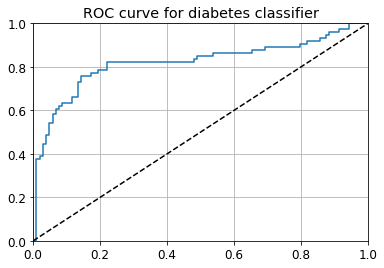

In [367]:
cat_train_pred = cat_model.predict(x_train)
cat_train_acc = np.sqrt(accuracy_score(y_train, cat_train_pred))
print('훈련 정확도 : {:.4f}'.format(cat_train_acc))


preds = cat_model.predict(x_test)
cat_test_acc = np.sqrt(accuracy_score(y_test, preds))
print("예측 정확도 : {:.4f}".format(cat_test_acc))
print(" < Confusion Matrix > \n {}".format(confusion_matrix(y_test , preds)))

preds_prob = cat_model.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, preds_prob[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# 결과 요약표를 만들기 위해 Dict 형태로 저장
models_result_base_1["CatBoostClassifier_train"] = round(cat_train_acc,4)
models_result_base_1["CatBoostClassifier_test"] = round(cat_test_acc, 4)

### 변수 중요도 확인

In [368]:
feature_importance_df = pd.DataFrame.from_dict(dict(zip(cat_model.feature_names_,
                                                        cat_model.feature_importances_)),orient="index",columns=["feature_value"]) 

In [369]:
feature_importance_df.sort_values(by=["feature_value"],ascending=False)

,feature_value
Sex,48.826915
Pclass,20.440351
Age,10.375898
Fare,6.118402
SibSp,5.731398
Embarked,5.452345
Parch,3.054691


### Titanic 생존자 예측모델링(Base2)

In [370]:
df_base2 = df.copy()

In [371]:
df_base2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [372]:
del df_base2['Name']
del df_base2['PassengerId']

In [373]:
df_base2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


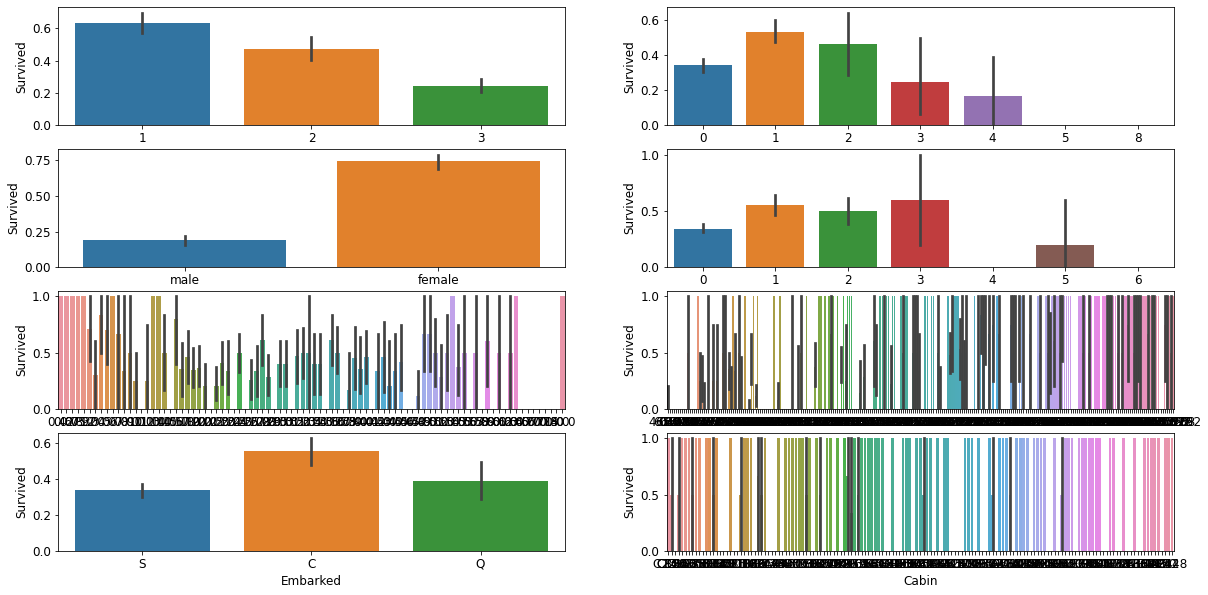

In [374]:
fig ,ax = plt.subplots(nrows=4 , ncols=2 , figsize=(20,10))
sns.barplot(x=df_base2['Pclass'], y =df_base2['Survived'] , data = df_base2, ax = ax[0,0])
sns.barplot(x=df_base2['Sex'], y =df_base2['Survived'] , data = df_base2, ax = ax[1,0])
sns.barplot(x=df_base2['SibSp'], y =df_base2['Survived'] , data = df_base2, ax = ax[0,1])
sns.barplot(x=df_base2['Parch'], y =df_base2['Survived'] , data = df_base2, ax = ax[1,1])
sns.barplot(x=df_base2['Age'], y =df_base2['Survived'] , data = df_base2, ax = ax[2,0])
sns.barplot(x=df_base2['Fare'], y =df_base2['Survived'] , data = df_base2, ax = ax[2,1])
sns.barplot(x=df_base2['Embarked'], y =df_base2['Survived'] , data = df_base2, ax = ax[3,0])
sns.barplot(x=df_base2['Cabin'], y =df_base2['Survived'] , data = df_base2, ax = ax[3,1])

plt.show()



In [375]:
print(df_base2['Fare'].min(),df_base2['Fare'].max())

0.0 512.3292


In [376]:
df_base2[df_base2["Age"].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
17,1,2,male,NaN,0,0,244373,13.0000,NaN,S
19,1,3,female,NaN,0,0,2649,7.2250,NaN,C
26,0,3,male,NaN,0,0,2631,7.2250,NaN,C
28,1,3,female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...
859,0,3,male,NaN,0,0,2629,7.2292,NaN,C
863,0,3,female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,0,3,male,NaN,0,0,345777,9.5000,NaN,S
878,0,3,male,NaN,0,0,349217,7.8958,NaN,S


In [377]:
df_base2[df_base2['Fare'] == 0]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,0,3,male,36.0,0,0,LINE,0.0,NaN,S
263,0,1,male,40.0,0,0,112059,0.0,B94,S
271,1,3,male,25.0,0,0,LINE,0.0,NaN,S
277,0,2,male,NaN,0,0,239853,0.0,NaN,S
302,0,3,male,19.0,0,0,LINE,0.0,NaN,S
413,0,2,male,NaN,0,0,239853,0.0,NaN,S
466,0,2,male,NaN,0,0,239853,0.0,NaN,S
481,0,2,male,NaN,0,0,239854,0.0,NaN,S
597,0,3,male,49.0,0,0,LINE,0.0,NaN,S
633,0,1,male,NaN,0,0,112052,0.0,NaN,S


### Age의 결측치 처리 및 Age, Fare를 일정 구간으로 나뉘는 범주형 변수로 변경

In [378]:
df_base2['Fare_range'] = round(df_base2['Fare'] / 20,0)

In [379]:
df_base2['Fare_range'] = df_base2['Fare_range'].astype(int)

In [380]:
df_base2['Fare_range'].value_counts()

0     336
1     315
2      80
3      55
4      48
6      11
11      9
8       9
7       9
5       8
13      6
26      3
12      2
Name: Fare_range, dtype: int64

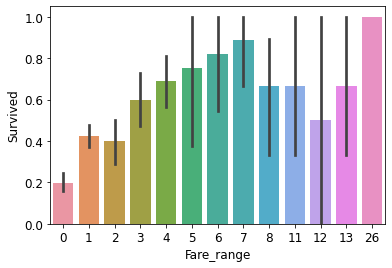

In [381]:
sns.barplot(x=df_base2['Fare_range'], y =df_base2['Survived'] , data = df_base2)

In [382]:
df_base2[df_base2['Age'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_range
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q,0
17,1,2,male,NaN,0,0,244373,13.0000,NaN,S,1
19,1,3,female,NaN,0,0,2649,7.2250,NaN,C,0
26,0,3,male,NaN,0,0,2631,7.2250,NaN,C,0
28,1,3,female,NaN,0,0,330959,7.8792,NaN,Q,0
...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,male,NaN,0,0,2629,7.2292,NaN,C,0
863,0,3,female,NaN,8,2,CA. 2343,69.5500,NaN,S,3
868,0,3,male,NaN,0,0,345777,9.5000,NaN,S,0
878,0,3,male,NaN,0,0,349217,7.8958,NaN,S,0


In [383]:
df_base2["Age"].fillna(df_base2.groupby(["Survived", "Pclass", "Sex"])["Age"].transform('median'), inplace = True)

In [384]:
df_base2['Age_range'] = round(df_base2['Age'] / 10,0)

In [385]:
df_base2['Age_range'] = df_base2['Age_range'].astype(int)

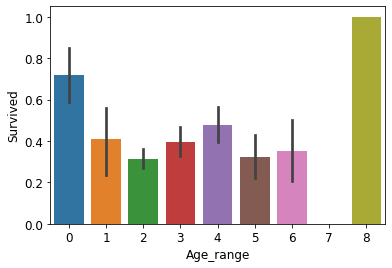

In [386]:
sns.barplot(x=df_base2['Age_range'], y =df_base2['Survived'] , data = df_base2)

In [387]:
df_base2.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         687
Embarked        2
Fare_range      0
Age_range       0
dtype: int64

In [388]:
del df_base2['Cabin']
del df_base2['Ticket']

In [389]:
idx_em_nan = list(df_base2[df_base2['Embarked'].isnull()].index)
df_base2 = df_base2.drop(idx_em_nan)

In [390]:
df_base2.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Fare_range    0
Age_range     0
dtype: int64

In [391]:
df_base2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_range,Age_range
0,0,3,male,22.0,1,0,7.2500,S,0,2
1,1,1,female,38.0,1,0,71.2833,C,4,4
2,1,3,female,26.0,0,0,7.9250,S,0,3
3,1,1,female,35.0,1,0,53.1000,S,3,4
4,0,3,male,35.0,0,0,8.0500,S,0,4


In [392]:
del df_base2['Age']
del df_base2['Fare']

In [393]:
df_base2.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Fare_range,Age_range
0,0,3,male,1,0,S,0,2
1,1,1,female,1,0,C,4,4
2,1,3,female,0,0,S,0,3
3,1,1,female,1,0,S,3,4
4,0,3,male,0,0,S,0,4


In [394]:
df_base2['Age_range'] = df_base2['Age_range'].astype(object)
df_base2['Fare_range'] = df_base2['Fare_range'].astype(object)

In [395]:
train_data = df_base2.drop(columns=["Survived"])
target_data = df_base2["Survived"].astype(int)

### 범주형 피쳐의 라벨인코딩

In [396]:
for col in train_data.columns.tolist():
    if train_data[col].dtype =="object":
        encoder = LabelEncoder()
        encoder.fit(train_data[col])
        train_data[col] = encoder.fit_transform(train_data[col])

### 훈련/검증 데이터셋 구분

In [397]:
x_train , x_test , y_train , y_test = train_test_split(train_data ,
                                                      target_data, 
                                                      test_size=0.2, 
                                                      random_state=2020)

### 모델링(Logistic Regression, RandomForest, DecisionTree)

In [398]:
lr_clf_2 = LogisticRegression(random_state=2020)
rf_clf_2 = RandomForestClassifier(random_state=2020)
dt_clf_2 = DecisionTreeClassifier(random_state=2020)

In [399]:
models = [[lr_clf_2,"LogisticRegression"], [rf_clf_2,"RandomForestClassifier"], [dt_clf_2,"DecisionTreeClassifier"]]

In [400]:
models_result_base_2 = {}

LogisticRegression
교차 검증 0 정확도 0.8671
교차 검증 1 정확도 0.8099
교차 검증 2 정확도 0.8662
교차 검증 3 정확도 0.7676
교차 검증 4 정확도 0.8028
훈련평균정확도 0.8227
예측 정확도 : 0.7921
 < Confusion Matrix > 
 [[89 15]
 [22 52]]


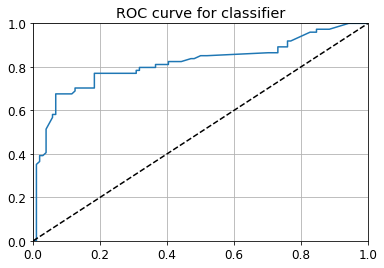



RandomForestClassifier
교차 검증 0 정확도 0.8881
교차 검증 1 정확도 0.8099
교차 검증 2 정확도 0.8592
교차 검증 3 정확도 0.7394
교차 검증 4 정확도 0.8662
훈련평균정확도 0.8326
예측 정확도 : 0.7921
 < Confusion Matrix > 
 [[90 14]
 [23 51]]


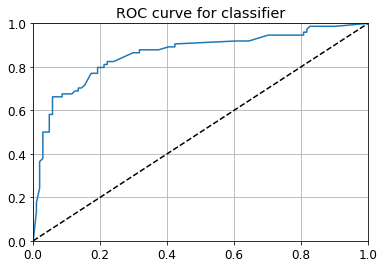



DecisionTreeClassifier
교차 검증 0 정확도 0.8462
교차 검증 1 정확도 0.7958
교차 검증 2 정확도 0.8521
교차 검증 3 정확도 0.7394
교차 검증 4 정확도 0.8028
훈련평균정확도 0.8073
예측 정확도 : 0.7865
 < Confusion Matrix > 
 [[91 13]
 [25 49]]


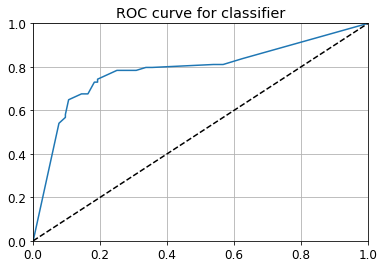

In [401]:
for tr_models, model_name in models:
    
    print(model_name)
    
    tr_models.fit(x_train, y_train)
    
    scores = cross_val_score(tr_models, x_train, y_train, cv=5)
    
    models_pred = tr_models.predict(x_test)
        
    for iter_count , accuracy in enumerate(scores):
        print("교차 검증 {} 정확도 {:.4f}".format(iter_count , accuracy))
    print("훈련평균정확도 {:.4f}".format(np.mean(scores)))
    
    preds = tr_models.predict(x_test)
    acc = accuracy_score(y_test , preds)
    
    print("예측 정확도 : {:.4f}".format(acc))
    print(" < Confusion Matrix > \n {}".format(confusion_matrix(y_test , preds)))
    
    preds_prob = tr_models.predict_proba(x_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, preds_prob[:,1])

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for classifier')
    # plt.xlabel('False Positive Rate (1 - Specificity)')
    # plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()
    
    print("\n")    
    
    
    # 결과 요약표를 만들기 위해 Dict 형태로 저장
    tr_models_train = str(model_name) +'_Train'
    tr_models_test = str(model_name) +'_test'
    models_result_base_2[tr_models_train] = round(np.mean(scores),4)
    models_result_base_2[tr_models_test] = round(acc, 4)

### 모델링(Catboost)

In [402]:
train_data = df_base2.drop(columns=["Survived"])
target_data = df_base2["Survived"].astype(int)

In [403]:
train_data.dtypes

Pclass        object
Sex           object
SibSp         object
Parch         object
Embarked      object
Fare_range    object
Age_range     object
dtype: object

In [404]:
x_train , x_test , y_train , y_test = train_test_split(train_data ,
                                                      target_data, 
                                                      test_size=0.2, 
                                                      random_state=2020)

In [405]:
object_col_index = []
for index , col in enumerate(x_train.columns.tolist()):
    if x_train[col].dtype =="object":
        object_col_index.append(index)

In [406]:
object_col_index

[0, 1, 2, 3, 4, 5, 6]

In [407]:
cat_model_2 = CatBoostClassifier(iterations =2020 , 
                          learning_rate = 0.003,
                          depth = 4,
                          l2_leaf_reg = 3,
                          loss_function ="Logloss")

In [408]:
cat_model_2.fit(x_train , y_train, cat_features=object_col_index)

0:	learn: 0.6912839	total: 14.4ms	remaining: 29.1s
1:	learn: 0.6894342	total: 26.5ms	remaining: 26.7s
2:	learn: 0.6876086	total: 37.1ms	remaining: 24.9s
3:	learn: 0.6857858	total: 53ms	remaining: 26.7s
4:	learn: 0.6839830	total: 56.8ms	remaining: 22.9s
5:	learn: 0.6822111	total: 58.4ms	remaining: 19.6s
6:	learn: 0.6809721	total: 64.9ms	remaining: 18.7s
7:	learn: 0.6791558	total: 70.1ms	remaining: 17.6s
8:	learn: 0.6773267	total: 71.9ms	remaining: 16.1s
9:	learn: 0.6755961	total: 73.4ms	remaining: 14.8s
10:	learn: 0.6737965	total: 75.3ms	remaining: 13.7s
11:	learn: 0.6720527	total: 79.8ms	remaining: 13.3s
12:	learn: 0.6702428	total: 81.5ms	remaining: 12.6s
13:	learn: 0.6685144	total: 83.4ms	remaining: 11.9s
14:	learn: 0.6668063	total: 85.6ms	remaining: 11.4s
15:	learn: 0.6650626	total: 87.5ms	remaining: 11s
16:	learn: 0.6633879	total: 89.2ms	remaining: 10.5s
17:	learn: 0.6617008	total: 91.5ms	remaining: 10.2s
18:	learn: 0.6600648	total: 92.6ms	remaining: 9.75s
19:	learn: 0.6584155	total

212:	learn: 0.4906962	total: 504ms	remaining: 4.28s
213:	learn: 0.4901040	total: 506ms	remaining: 4.27s
214:	learn: 0.4897718	total: 508ms	remaining: 4.26s
215:	learn: 0.4894078	total: 509ms	remaining: 4.25s
216:	learn: 0.4890896	total: 511ms	remaining: 4.24s
217:	learn: 0.4886109	total: 514ms	remaining: 4.25s
218:	learn: 0.4882046	total: 520ms	remaining: 4.28s
219:	learn: 0.4876222	total: 522ms	remaining: 4.27s
220:	learn: 0.4870143	total: 524ms	remaining: 4.27s
221:	learn: 0.4864900	total: 531ms	remaining: 4.3s
222:	learn: 0.4860284	total: 532ms	remaining: 4.29s
223:	learn: 0.4855766	total: 534ms	remaining: 4.28s
224:	learn: 0.4850679	total: 536ms	remaining: 4.27s
225:	learn: 0.4846654	total: 537ms	remaining: 4.26s
226:	learn: 0.4841522	total: 539ms	remaining: 4.26s
227:	learn: 0.4839233	total: 540ms	remaining: 4.24s
228:	learn: 0.4836372	total: 543ms	remaining: 4.25s
229:	learn: 0.4833413	total: 546ms	remaining: 4.25s
230:	learn: 0.4830631	total: 547ms	remaining: 4.24s
231:	learn: 0

453:	learn: 0.4268413	total: 989ms	remaining: 3.41s
454:	learn: 0.4267070	total: 992ms	remaining: 3.41s
455:	learn: 0.4265750	total: 994ms	remaining: 3.41s
456:	learn: 0.4263929	total: 995ms	remaining: 3.4s
457:	learn: 0.4262892	total: 999ms	remaining: 3.41s
458:	learn: 0.4260233	total: 1s	remaining: 3.4s
459:	learn: 0.4259589	total: 1s	remaining: 3.41s
460:	learn: 0.4257321	total: 1.01s	remaining: 3.42s
461:	learn: 0.4255922	total: 1.01s	remaining: 3.41s
462:	learn: 0.4254740	total: 1.01s	remaining: 3.41s
463:	learn: 0.4252880	total: 1.02s	remaining: 3.41s
464:	learn: 0.4251778	total: 1.02s	remaining: 3.41s
465:	learn: 0.4250241	total: 1.02s	remaining: 3.41s
466:	learn: 0.4248928	total: 1.02s	remaining: 3.4s
467:	learn: 0.4247244	total: 1.03s	remaining: 3.4s
468:	learn: 0.4245474	total: 1.03s	remaining: 3.4s
469:	learn: 0.4243231	total: 1.03s	remaining: 3.4s
470:	learn: 0.4241994	total: 1.03s	remaining: 3.39s
471:	learn: 0.4240363	total: 1.03s	remaining: 3.39s
472:	learn: 0.4238247	to

613:	learn: 0.4083234	total: 1.32s	remaining: 3.02s
614:	learn: 0.4082844	total: 1.32s	remaining: 3.02s
615:	learn: 0.4081845	total: 1.32s	remaining: 3.02s
616:	learn: 0.4080282	total: 1.33s	remaining: 3.03s
617:	learn: 0.4079159	total: 1.34s	remaining: 3.03s
618:	learn: 0.4077939	total: 1.34s	remaining: 3.03s
619:	learn: 0.4077252	total: 1.34s	remaining: 3.04s
620:	learn: 0.4076417	total: 1.35s	remaining: 3.04s
621:	learn: 0.4075485	total: 1.35s	remaining: 3.04s
622:	learn: 0.4075074	total: 1.36s	remaining: 3.04s
623:	learn: 0.4073891	total: 1.37s	remaining: 3.06s
624:	learn: 0.4072679	total: 1.37s	remaining: 3.06s
625:	learn: 0.4071832	total: 1.37s	remaining: 3.05s
626:	learn: 0.4070926	total: 1.37s	remaining: 3.05s
627:	learn: 0.4070066	total: 1.38s	remaining: 3.05s
628:	learn: 0.4068575	total: 1.38s	remaining: 3.05s
629:	learn: 0.4068003	total: 1.39s	remaining: 3.06s
630:	learn: 0.4067958	total: 1.39s	remaining: 3.05s
631:	learn: 0.4067332	total: 1.39s	remaining: 3.06s
632:	learn: 

813:	learn: 0.3934939	total: 1.8s	remaining: 2.67s
814:	learn: 0.3934453	total: 1.81s	remaining: 2.67s
815:	learn: 0.3933903	total: 1.81s	remaining: 2.68s
816:	learn: 0.3933016	total: 1.82s	remaining: 2.68s
817:	learn: 0.3931917	total: 1.82s	remaining: 2.68s
818:	learn: 0.3931360	total: 1.83s	remaining: 2.68s
819:	learn: 0.3931106	total: 1.83s	remaining: 2.68s
820:	learn: 0.3930727	total: 1.84s	remaining: 2.68s
821:	learn: 0.3929357	total: 1.84s	remaining: 2.69s
822:	learn: 0.3928466	total: 1.84s	remaining: 2.68s
823:	learn: 0.3927606	total: 1.84s	remaining: 2.68s
824:	learn: 0.3927118	total: 1.85s	remaining: 2.67s
825:	learn: 0.3926975	total: 1.85s	remaining: 2.67s
826:	learn: 0.3926352	total: 1.85s	remaining: 2.67s
827:	learn: 0.3926179	total: 1.85s	remaining: 2.66s
828:	learn: 0.3925831	total: 1.85s	remaining: 2.66s
829:	learn: 0.3925531	total: 1.85s	remaining: 2.66s
830:	learn: 0.3925214	total: 1.86s	remaining: 2.66s
831:	learn: 0.3924995	total: 1.86s	remaining: 2.66s
832:	learn: 0

1017:	learn: 0.3830453	total: 2.48s	remaining: 2.44s
1018:	learn: 0.3829373	total: 2.49s	remaining: 2.45s
1019:	learn: 0.3829066	total: 2.5s	remaining: 2.45s
1020:	learn: 0.3828775	total: 2.5s	remaining: 2.45s
1021:	learn: 0.3828539	total: 2.5s	remaining: 2.44s
1022:	learn: 0.3827985	total: 2.51s	remaining: 2.44s
1023:	learn: 0.3827372	total: 2.51s	remaining: 2.44s
1024:	learn: 0.3826969	total: 2.51s	remaining: 2.44s
1025:	learn: 0.3826680	total: 2.51s	remaining: 2.43s
1026:	learn: 0.3825869	total: 2.52s	remaining: 2.44s
1027:	learn: 0.3825429	total: 2.52s	remaining: 2.43s
1028:	learn: 0.3825249	total: 2.52s	remaining: 2.43s
1029:	learn: 0.3824636	total: 2.53s	remaining: 2.43s
1030:	learn: 0.3823838	total: 2.53s	remaining: 2.43s
1031:	learn: 0.3823737	total: 2.54s	remaining: 2.43s
1032:	learn: 0.3823620	total: 2.54s	remaining: 2.42s
1033:	learn: 0.3823316	total: 2.54s	remaining: 2.42s
1034:	learn: 0.3822996	total: 2.54s	remaining: 2.42s
1035:	learn: 0.3822476	total: 2.55s	remaining: 2.

1179:	learn: 0.3763453	total: 2.98s	remaining: 2.12s
1180:	learn: 0.3762888	total: 2.98s	remaining: 2.12s
1181:	learn: 0.3762629	total: 2.98s	remaining: 2.12s
1182:	learn: 0.3762271	total: 2.99s	remaining: 2.11s
1183:	learn: 0.3761711	total: 2.99s	remaining: 2.11s
1184:	learn: 0.3761710	total: 2.99s	remaining: 2.11s
1185:	learn: 0.3761347	total: 2.99s	remaining: 2.1s
1186:	learn: 0.3760749	total: 3s	remaining: 2.1s
1187:	learn: 0.3760747	total: 3s	remaining: 2.1s
1188:	learn: 0.3760676	total: 3s	remaining: 2.1s
1189:	learn: 0.3760528	total: 3s	remaining: 2.09s
1190:	learn: 0.3760149	total: 3s	remaining: 2.09s
1191:	learn: 0.3759848	total: 3s	remaining: 2.09s
1192:	learn: 0.3759732	total: 3s	remaining: 2.08s
1193:	learn: 0.3759570	total: 3.01s	remaining: 2.08s
1194:	learn: 0.3759270	total: 3.01s	remaining: 2.08s
1195:	learn: 0.3759052	total: 3.01s	remaining: 2.07s
1196:	learn: 0.3758503	total: 3.01s	remaining: 2.07s
1197:	learn: 0.3758108	total: 3.01s	remaining: 2.07s
1198:	learn: 0.375

1351:	learn: 0.3704653	total: 3.49s	remaining: 1.73s
1352:	learn: 0.3704254	total: 3.49s	remaining: 1.72s
1353:	learn: 0.3703616	total: 3.49s	remaining: 1.72s
1354:	learn: 0.3703142	total: 3.5s	remaining: 1.72s
1355:	learn: 0.3702841	total: 3.5s	remaining: 1.72s
1356:	learn: 0.3702533	total: 3.51s	remaining: 1.71s
1357:	learn: 0.3702083	total: 3.51s	remaining: 1.71s
1358:	learn: 0.3701913	total: 3.51s	remaining: 1.71s
1359:	learn: 0.3701398	total: 3.52s	remaining: 1.71s
1360:	learn: 0.3701105	total: 3.52s	remaining: 1.7s
1361:	learn: 0.3700874	total: 3.52s	remaining: 1.7s
1362:	learn: 0.3700560	total: 3.52s	remaining: 1.7s
1363:	learn: 0.3700489	total: 3.52s	remaining: 1.69s
1364:	learn: 0.3699733	total: 3.52s	remaining: 1.69s
1365:	learn: 0.3699322	total: 3.53s	remaining: 1.69s
1366:	learn: 0.3698851	total: 3.53s	remaining: 1.69s
1367:	learn: 0.3698628	total: 3.54s	remaining: 1.69s
1368:	learn: 0.3698226	total: 3.54s	remaining: 1.68s
1369:	learn: 0.3698087	total: 3.54s	remaining: 1.68

1529:	learn: 0.3649122	total: 3.99s	remaining: 1.28s
1530:	learn: 0.3648962	total: 3.99s	remaining: 1.27s
1531:	learn: 0.3648268	total: 3.99s	remaining: 1.27s
1532:	learn: 0.3647991	total: 3.99s	remaining: 1.27s
1533:	learn: 0.3647780	total: 4s	remaining: 1.26s
1534:	learn: 0.3647463	total: 4s	remaining: 1.26s
1535:	learn: 0.3647366	total: 4s	remaining: 1.26s
1536:	learn: 0.3647088	total: 4s	remaining: 1.26s
1537:	learn: 0.3646276	total: 4s	remaining: 1.25s
1538:	learn: 0.3646256	total: 4s	remaining: 1.25s
1539:	learn: 0.3645836	total: 4.01s	remaining: 1.25s
1540:	learn: 0.3645603	total: 4.01s	remaining: 1.25s
1541:	learn: 0.3645248	total: 4.01s	remaining: 1.24s
1542:	learn: 0.3644894	total: 4.01s	remaining: 1.24s
1543:	learn: 0.3644474	total: 4.02s	remaining: 1.24s
1544:	learn: 0.3644404	total: 4.02s	remaining: 1.24s
1545:	learn: 0.3644234	total: 4.02s	remaining: 1.23s
1546:	learn: 0.3643890	total: 4.02s	remaining: 1.23s
1547:	learn: 0.3643563	total: 4.03s	remaining: 1.23s
1548:	learn

1693:	learn: 0.3607220	total: 4.49s	remaining: 865ms
1694:	learn: 0.3606274	total: 4.5s	remaining: 862ms
1695:	learn: 0.3606126	total: 4.5s	remaining: 859ms
1696:	learn: 0.3605600	total: 4.5s	remaining: 856ms
1697:	learn: 0.3605072	total: 4.5s	remaining: 854ms
1698:	learn: 0.3604811	total: 4.5s	remaining: 851ms
1699:	learn: 0.3604465	total: 4.5s	remaining: 848ms
1700:	learn: 0.3604271	total: 4.51s	remaining: 845ms
1701:	learn: 0.3603859	total: 4.51s	remaining: 843ms
1702:	learn: 0.3603626	total: 4.51s	remaining: 841ms
1703:	learn: 0.3603251	total: 4.52s	remaining: 838ms
1704:	learn: 0.3602885	total: 4.52s	remaining: 835ms
1705:	learn: 0.3602141	total: 4.52s	remaining: 832ms
1706:	learn: 0.3601733	total: 4.52s	remaining: 829ms
1707:	learn: 0.3601412	total: 4.53s	remaining: 827ms
1708:	learn: 0.3601364	total: 4.53s	remaining: 824ms
1709:	learn: 0.3601162	total: 4.53s	remaining: 821ms
1710:	learn: 0.3601006	total: 4.53s	remaining: 818ms
1711:	learn: 0.3600782	total: 4.53s	remaining: 815ms

1880:	learn: 0.3556543	total: 5s	remaining: 370ms
1881:	learn: 0.3556397	total: 5s	remaining: 367ms
1882:	learn: 0.3556260	total: 5.01s	remaining: 364ms
1883:	learn: 0.3555834	total: 5.01s	remaining: 362ms
1884:	learn: 0.3555800	total: 5.01s	remaining: 359ms
1885:	learn: 0.3555717	total: 5.02s	remaining: 356ms
1886:	learn: 0.3555503	total: 5.02s	remaining: 354ms
1887:	learn: 0.3555216	total: 5.02s	remaining: 351ms
1888:	learn: 0.3554953	total: 5.02s	remaining: 348ms
1889:	learn: 0.3554575	total: 5.02s	remaining: 346ms
1890:	learn: 0.3554383	total: 5.03s	remaining: 343ms
1891:	learn: 0.3554162	total: 5.03s	remaining: 340ms
1892:	learn: 0.3553884	total: 5.03s	remaining: 337ms
1893:	learn: 0.3553247	total: 5.03s	remaining: 335ms
1894:	learn: 0.3553176	total: 5.03s	remaining: 332ms
1895:	learn: 0.3552869	total: 5.04s	remaining: 329ms
1896:	learn: 0.3552208	total: 5.04s	remaining: 327ms
1897:	learn: 0.3551978	total: 5.04s	remaining: 324ms
1898:	learn: 0.3551730	total: 5.04s	remaining: 321ms

훈련 정확도 : 0.9209
예측 정확도 : 0.8900
 < Confusion Matrix > 
 [[97  7]
 [30 44]]


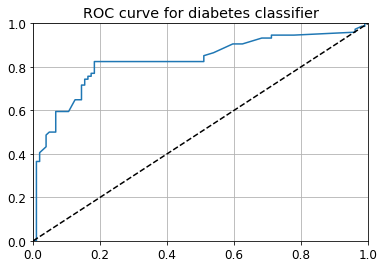

In [409]:
cat_train_pred = cat_model_2.predict(x_train)
cat_train_acc = np.sqrt(accuracy_score(y_train, cat_train_pred))
print('훈련 정확도 : {:.4f}'.format(cat_train_acc))


preds = cat_model_2.predict(x_test)
cat_test_acc = np.sqrt(accuracy_score(y_test, preds))
print("예측 정확도 : {:.4f}".format(cat_test_acc))
print(" < Confusion Matrix > \n {}".format(confusion_matrix(y_test , preds)))

preds_prob = cat_model_2.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, preds_prob[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# 결과 요약표를 만들기 위해 Dict 형태로 저장
models_result_base_2["CatBoostClassifier_train"] = round(cat_train_acc,4)
models_result_base_2["CatBoostClassifier_test"] = round(cat_test_acc, 4)

### 변수 중요도 확인

In [410]:
feature_importance_df = pd.DataFrame.from_dict(dict(zip(cat_model_2.feature_names_,
                                                        cat_model_2.feature_importances_)),orient="index",columns=["feature_value"]) 


feature_importance_df.sort_values(by=["feature_value"],ascending=False)

,feature_value
Sex,43.420535
Pclass,22.613113
Age_range,12.943688
SibSp,6.146870
Fare_range,5.866730
Embarked,5.244842
Parch,3.764221


### Titanic 생존자 예측모델링(Base3)

In [411]:
df_base3 = df_base2.copy()

In [412]:
df_base3.dtypes

Survived      object
Pclass        object
Sex           object
SibSp         object
Parch         object
Embarked      object
Fare_range    object
Age_range     object
dtype: object

### SibSP, Parch의 값을 더한 SibSp_Parch 피쳐 생성

In [413]:
df_base3['SibSp_Parch']=df_base3['Parch'].astype(int) + df_base3['SibSp'].astype(int)

In [414]:
df_base3['SibSp_Parch'].value_counts()

0     535
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: SibSp_Parch, dtype: int64

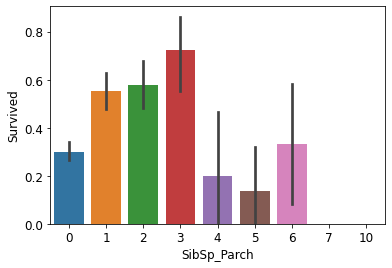

In [415]:
sns.barplot(x=df_base3['SibSp_Parch'], y =df_base3['Survived'] , data = df_base3)

In [416]:
df_base3['SibSp_Parch'] = df_base3['SibSp_Parch'].astype(object)

In [417]:
del df_base3['SibSp']
del df_base3['Parch']

In [418]:
train_data = df_base3.drop(columns=["Survived"])
target_data = df_base3["Survived"].astype(int)

### survived 피쳐의 class 불균형을 해소하기 위해 Up-sampling

In [419]:
target_data.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [420]:
sm = SMOTENC(random_state=2020 ,categorical_features=[0,1, 2, 3, 4])

In [421]:
X_res , y_res = sm.fit_resample(train_data,target_data)

In [422]:
train_data = pd.DataFrame(X_res, columns=train_data.columns)
target_data = pd.Series(y_res)

In [423]:
train_data.shape

(1098, 6)

In [424]:
target_data.value_counts()

1    549
0    549
Name: Survived, dtype: int64

### 범주형 피쳐의 라벨인코딩

In [425]:
for col in train_data.columns.tolist():
    if train_data[col].dtype =="object":
        encoder = LabelEncoder()
        encoder.fit(train_data[col])
        train_data[col] = encoder.fit_transform(train_data[col])

### 훈련/검증 데이터셋 구분

In [426]:
x_train , x_test , y_train , y_test = train_test_split(train_data ,
                                                      target_data, 
                                                      test_size=0.2, 
                                                      random_state=2020)

### 모델링(Logistic Regression, RandomForest, DecisionTree)

In [427]:
lr_clf_3 = LogisticRegression(random_state=2020)
rf_clf_3 = RandomForestClassifier(random_state=2020)
dt_clf_3 = DecisionTreeClassifier(random_state=2020)

In [428]:
models = [[lr_clf_3,"LogisticRegression"], [rf_clf_3,"RandomForestClassifier"], [dt_clf_3,"DecisionTreeClassifier"]]

In [429]:
models_result_base_3 = {}

LogisticRegression
교차 검증 0 정확도 0.8239
교차 검증 1 정확도 0.8068
교차 검증 2 정확도 0.8352
교차 검증 3 정확도 0.8057
교차 검증 4 정확도 0.7600
훈련평균정확도 0.8063
예측 정확도 : 0.7864
 < Confusion Matrix > 
 [[ 73  21]
 [ 26 100]]


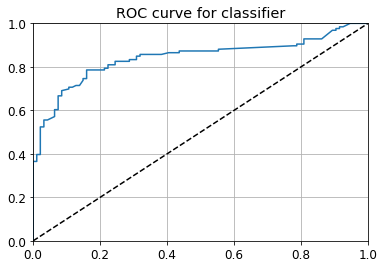



RandomForestClassifier
교차 검증 0 정확도 0.8239
교차 검증 1 정확도 0.8352
교차 검증 2 정확도 0.8295
교차 검증 3 정확도 0.8171
교차 검증 4 정확도 0.7943
훈련평균정확도 0.8200
예측 정확도 : 0.8227
 < Confusion Matrix > 
 [[83 11]
 [28 98]]


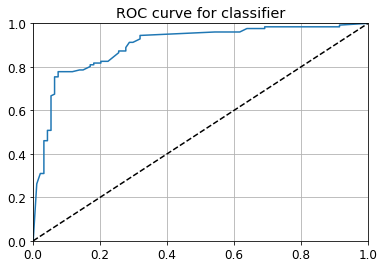



DecisionTreeClassifier
교차 검증 0 정확도 0.8409
교차 검증 1 정확도 0.8295
교차 검증 2 정확도 0.8409
교차 검증 3 정확도 0.8114
교차 검증 4 정확도 0.8057
훈련평균정확도 0.8257
예측 정확도 : 0.8091
 < Confusion Matrix > 
 [[84 10]
 [32 94]]


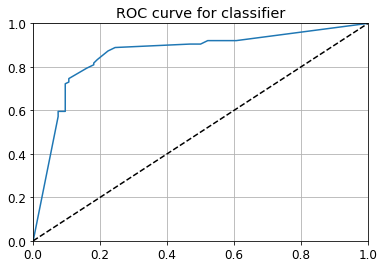

In [430]:
for tr_models, model_name in models:
    
    print(model_name)
    
    tr_models.fit(x_train, y_train)
    
    scores = cross_val_score(tr_models, x_train, y_train, cv=5)
    
    models_pred = tr_models.predict(x_test)
        
    for iter_count , accuracy in enumerate(scores):
        print("교차 검증 {} 정확도 {:.4f}".format(iter_count , accuracy))
    print("훈련평균정확도 {:.4f}".format(np.mean(scores)))
    
    preds = tr_models.predict(x_test)
    acc = accuracy_score(y_test , preds)
    
    print("예측 정확도 : {:.4f}".format(acc))
    print(" < Confusion Matrix > \n {}".format(confusion_matrix(y_test , preds)))
    
    preds_prob = tr_models.predict_proba(x_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, preds_prob[:,1])

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for classifier')
    # plt.xlabel('False Positive Rate (1 - Specificity)')
    # plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()
    
    print("\n")
    
    # 결과 요약표를 만들기 위해 Dict 형태로 저장       
    tr_models_train = str(model_name) +'_Train'
    tr_models_test = str(model_name) +'_test'
    models_result_base_3[tr_models_train] = round(np.mean(scores),4)
    models_result_base_3[tr_models_test] = round(acc, 4)

### 모델링(Catboost)

In [431]:
train_data = df_base3.drop(columns=["Survived"])
target_data = df_base3["Survived"].astype(int)

In [432]:
train_data.dtypes

Pclass         object
Sex            object
Embarked       object
Fare_range     object
Age_range      object
SibSp_Parch    object
dtype: object

In [433]:
train_data['SibSp_Parch'] = train_data['SibSp_Parch'].astype(int)

In [434]:
sm = SMOTENC(random_state=2020 ,categorical_features=[0, 1, 2, 3, 4])

In [435]:
X_res , y_res = sm.fit_resample(train_data,target_data)

In [436]:
train_data = pd.DataFrame(X_res, columns=train_data.columns)
target_data = pd.Series(y_res)

In [437]:
x_train , x_test , y_train , y_test = train_test_split(train_data ,
                                                      target_data, 
                                                      test_size=0.2, 
                                                      random_state=2020)

In [438]:
for col in train_data.columns.tolist():
    if train_data[col].dtype =="object":
        encoder = LabelEncoder()
        encoder.fit(train_data[col])
        train_data[col] = encoder.fit_transform(train_data[col])

In [439]:
object_col_index = []
for index , col in enumerate(x_train.columns.tolist()):
    if x_train[col].dtype =="object":
        object_col_index.append(index)


In [440]:
object_col_index

[0, 1, 2, 3, 4]

In [441]:
cat_model_3 = CatBoostClassifier(iterations =2020 , 
                          learning_rate = 0.003,
                          depth = 4,
                          l2_leaf_reg = 3,
                          loss_function ="Logloss")

In [442]:
cat_model_3.fit(x_train , y_train, cat_features=object_col_index)

0:	learn: 0.6913394	total: 30.3ms	remaining: 1m 1s
1:	learn: 0.6896811	total: 33.2ms	remaining: 33.5s
2:	learn: 0.6880356	total: 53.9ms	remaining: 36.2s
3:	learn: 0.6864098	total: 57.1ms	remaining: 28.8s
4:	learn: 0.6848113	total: 59.9ms	remaining: 24.1s
5:	learn: 0.6830921	total: 69ms	remaining: 23.2s
6:	learn: 0.6814023	total: 78.5ms	remaining: 22.6s
7:	learn: 0.6804017	total: 80.6ms	remaining: 20.3s
8:	learn: 0.6787782	total: 83.7ms	remaining: 18.7s
9:	learn: 0.6771157	total: 88.9ms	remaining: 17.9s
10:	learn: 0.6755052	total: 118ms	remaining: 21.6s
11:	learn: 0.6738497	total: 128ms	remaining: 21.4s
12:	learn: 0.6722135	total: 138ms	remaining: 21.3s
13:	learn: 0.6706987	total: 140ms	remaining: 20.1s
14:	learn: 0.6691493	total: 153ms	remaining: 20.5s
15:	learn: 0.6676016	total: 155ms	remaining: 19.5s
16:	learn: 0.6660489	total: 161ms	remaining: 19s
17:	learn: 0.6644461	total: 166ms	remaining: 18.5s
18:	learn: 0.6629471	total: 168ms	remaining: 17.7s
19:	learn: 0.6614395	total: 169ms	r

234:	learn: 0.4985752	total: 510ms	remaining: 3.87s
235:	learn: 0.4982142	total: 511ms	remaining: 3.87s
236:	learn: 0.4979209	total: 513ms	remaining: 3.86s
237:	learn: 0.4974923	total: 514ms	remaining: 3.85s
238:	learn: 0.4971630	total: 517ms	remaining: 3.85s
239:	learn: 0.4968178	total: 523ms	remaining: 3.88s
240:	learn: 0.4965079	total: 526ms	remaining: 3.88s
241:	learn: 0.4960817	total: 528ms	remaining: 3.88s
242:	learn: 0.4957743	total: 529ms	remaining: 3.87s
243:	learn: 0.4954880	total: 531ms	remaining: 3.87s
244:	learn: 0.4950793	total: 532ms	remaining: 3.86s
245:	learn: 0.4946743	total: 534ms	remaining: 3.85s
246:	learn: 0.4943190	total: 535ms	remaining: 3.84s
247:	learn: 0.4940784	total: 536ms	remaining: 3.83s
248:	learn: 0.4937311	total: 538ms	remaining: 3.82s
249:	learn: 0.4933329	total: 539ms	remaining: 3.81s
250:	learn: 0.4929422	total: 543ms	remaining: 3.83s
251:	learn: 0.4926923	total: 545ms	remaining: 3.82s
252:	learn: 0.4922790	total: 546ms	remaining: 3.81s
253:	learn: 

401:	learn: 0.4561821	total: 840ms	remaining: 3.38s
402:	learn: 0.4560444	total: 844ms	remaining: 3.38s
403:	learn: 0.4558529	total: 845ms	remaining: 3.38s
404:	learn: 0.4556825	total: 846ms	remaining: 3.38s
405:	learn: 0.4554904	total: 848ms	remaining: 3.37s
406:	learn: 0.4553039	total: 849ms	remaining: 3.37s
407:	learn: 0.4551907	total: 851ms	remaining: 3.36s
408:	learn: 0.4550971	total: 854ms	remaining: 3.37s
409:	learn: 0.4550089	total: 864ms	remaining: 3.39s
410:	learn: 0.4547939	total: 865ms	remaining: 3.39s
411:	learn: 0.4546290	total: 869ms	remaining: 3.39s
412:	learn: 0.4544780	total: 873ms	remaining: 3.4s
413:	learn: 0.4543530	total: 881ms	remaining: 3.42s
414:	learn: 0.4542091	total: 882ms	remaining: 3.41s
415:	learn: 0.4539312	total: 883ms	remaining: 3.41s
416:	learn: 0.4537814	total: 885ms	remaining: 3.4s
417:	learn: 0.4536266	total: 894ms	remaining: 3.43s
418:	learn: 0.4535045	total: 895ms	remaining: 3.42s
419:	learn: 0.4532609	total: 897ms	remaining: 3.42s
420:	learn: 0.

599:	learn: 0.4330728	total: 1.35s	remaining: 3.19s
600:	learn: 0.4329168	total: 1.35s	remaining: 3.18s
601:	learn: 0.4327778	total: 1.35s	remaining: 3.18s
602:	learn: 0.4327354	total: 1.35s	remaining: 3.17s
603:	learn: 0.4326522	total: 1.35s	remaining: 3.17s
604:	learn: 0.4326115	total: 1.35s	remaining: 3.16s
605:	learn: 0.4325034	total: 1.36s	remaining: 3.17s
606:	learn: 0.4324035	total: 1.36s	remaining: 3.17s
607:	learn: 0.4323071	total: 1.36s	remaining: 3.16s
608:	learn: 0.4322713	total: 1.36s	remaining: 3.16s
609:	learn: 0.4321968	total: 1.36s	remaining: 3.15s
610:	learn: 0.4321300	total: 1.36s	remaining: 3.15s
611:	learn: 0.4321052	total: 1.37s	remaining: 3.14s
612:	learn: 0.4320551	total: 1.37s	remaining: 3.14s
613:	learn: 0.4320035	total: 1.37s	remaining: 3.13s
614:	learn: 0.4319462	total: 1.37s	remaining: 3.13s
615:	learn: 0.4318980	total: 1.37s	remaining: 3.12s
616:	learn: 0.4318039	total: 1.37s	remaining: 3.12s
617:	learn: 0.4317750	total: 1.37s	remaining: 3.11s
618:	learn: 

770:	learn: 0.4214292	total: 1.68s	remaining: 2.73s
771:	learn: 0.4213961	total: 1.69s	remaining: 2.73s
772:	learn: 0.4213541	total: 1.69s	remaining: 2.73s
773:	learn: 0.4213083	total: 1.7s	remaining: 2.74s
774:	learn: 0.4212612	total: 1.7s	remaining: 2.74s
775:	learn: 0.4211913	total: 1.71s	remaining: 2.74s
776:	learn: 0.4211482	total: 1.71s	remaining: 2.73s
777:	learn: 0.4210678	total: 1.71s	remaining: 2.73s
778:	learn: 0.4210439	total: 1.71s	remaining: 2.73s
779:	learn: 0.4210243	total: 1.71s	remaining: 2.72s
780:	learn: 0.4209892	total: 1.71s	remaining: 2.72s
781:	learn: 0.4208928	total: 1.71s	remaining: 2.71s
782:	learn: 0.4208519	total: 1.72s	remaining: 2.71s
783:	learn: 0.4207597	total: 1.72s	remaining: 2.71s
784:	learn: 0.4207304	total: 1.72s	remaining: 2.7s
785:	learn: 0.4207108	total: 1.72s	remaining: 2.7s
786:	learn: 0.4207012	total: 1.72s	remaining: 2.69s
787:	learn: 0.4206658	total: 1.72s	remaining: 2.69s
788:	learn: 0.4206100	total: 1.72s	remaining: 2.69s
789:	learn: 0.42

967:	learn: 0.4119461	total: 2.19s	remaining: 2.38s
968:	learn: 0.4118711	total: 2.2s	remaining: 2.38s
969:	learn: 0.4117621	total: 2.21s	remaining: 2.39s
970:	learn: 0.4116853	total: 2.21s	remaining: 2.39s
971:	learn: 0.4116530	total: 2.22s	remaining: 2.39s
972:	learn: 0.4116012	total: 2.22s	remaining: 2.39s
973:	learn: 0.4115183	total: 2.22s	remaining: 2.38s
974:	learn: 0.4114804	total: 2.23s	remaining: 2.39s
975:	learn: 0.4114466	total: 2.23s	remaining: 2.38s
976:	learn: 0.4114171	total: 2.23s	remaining: 2.38s
977:	learn: 0.4113842	total: 2.24s	remaining: 2.38s
978:	learn: 0.4113573	total: 2.24s	remaining: 2.38s
979:	learn: 0.4113050	total: 2.24s	remaining: 2.38s
980:	learn: 0.4112704	total: 2.24s	remaining: 2.37s
981:	learn: 0.4112479	total: 2.24s	remaining: 2.37s
982:	learn: 0.4112129	total: 2.24s	remaining: 2.36s
983:	learn: 0.4111619	total: 2.24s	remaining: 2.36s
984:	learn: 0.4111371	total: 2.24s	remaining: 2.36s
985:	learn: 0.4110957	total: 2.25s	remaining: 2.35s
986:	learn: 0

1136:	learn: 0.4061183	total: 2.52s	remaining: 1.96s
1137:	learn: 0.4061062	total: 2.52s	remaining: 1.95s
1138:	learn: 0.4060876	total: 2.52s	remaining: 1.95s
1139:	learn: 0.4060735	total: 2.52s	remaining: 1.95s
1140:	learn: 0.4060641	total: 2.53s	remaining: 1.95s
1141:	learn: 0.4060367	total: 2.53s	remaining: 1.94s
1142:	learn: 0.4060097	total: 2.53s	remaining: 1.94s
1143:	learn: 0.4059915	total: 2.53s	remaining: 1.94s
1144:	learn: 0.4059656	total: 2.53s	remaining: 1.93s
1145:	learn: 0.4059080	total: 2.53s	remaining: 1.93s
1146:	learn: 0.4058713	total: 2.53s	remaining: 1.93s
1147:	learn: 0.4058172	total: 2.54s	remaining: 1.93s
1148:	learn: 0.4057585	total: 2.54s	remaining: 1.93s
1149:	learn: 0.4057563	total: 2.54s	remaining: 1.92s
1150:	learn: 0.4057160	total: 2.55s	remaining: 1.92s
1151:	learn: 0.4056926	total: 2.56s	remaining: 1.93s
1152:	learn: 0.4056731	total: 2.57s	remaining: 1.93s
1153:	learn: 0.4056416	total: 2.57s	remaining: 1.93s
1154:	learn: 0.4056057	total: 2.57s	remaining:

1324:	learn: 0.4005305	total: 3.01s	remaining: 1.58s
1325:	learn: 0.4004998	total: 3.01s	remaining: 1.58s
1326:	learn: 0.4004889	total: 3.01s	remaining: 1.57s
1327:	learn: 0.4004358	total: 3.02s	remaining: 1.57s
1328:	learn: 0.4004261	total: 3.03s	remaining: 1.58s
1329:	learn: 0.4004132	total: 3.04s	remaining: 1.58s
1330:	learn: 0.4003748	total: 3.05s	remaining: 1.58s
1331:	learn: 0.4003289	total: 3.06s	remaining: 1.58s
1332:	learn: 0.4002977	total: 3.06s	remaining: 1.58s
1333:	learn: 0.4002259	total: 3.06s	remaining: 1.57s
1334:	learn: 0.4001980	total: 3.06s	remaining: 1.57s
1335:	learn: 0.4001687	total: 3.06s	remaining: 1.57s
1336:	learn: 0.4001604	total: 3.07s	remaining: 1.57s
1337:	learn: 0.4001172	total: 3.07s	remaining: 1.56s
1338:	learn: 0.4000786	total: 3.08s	remaining: 1.56s
1339:	learn: 0.4000544	total: 3.08s	remaining: 1.56s
1340:	learn: 0.4000216	total: 3.08s	remaining: 1.56s
1341:	learn: 0.3999798	total: 3.09s	remaining: 1.56s
1342:	learn: 0.3999789	total: 3.09s	remaining:

1519:	learn: 0.3951408	total: 3.51s	remaining: 1.15s
1520:	learn: 0.3951160	total: 3.51s	remaining: 1.15s
1521:	learn: 0.3950876	total: 3.51s	remaining: 1.15s
1522:	learn: 0.3950562	total: 3.51s	remaining: 1.15s
1523:	learn: 0.3950282	total: 3.51s	remaining: 1.14s
1524:	learn: 0.3949978	total: 3.51s	remaining: 1.14s
1525:	learn: 0.3949814	total: 3.52s	remaining: 1.14s
1526:	learn: 0.3949788	total: 3.52s	remaining: 1.14s
1527:	learn: 0.3949659	total: 3.52s	remaining: 1.13s
1528:	learn: 0.3949649	total: 3.52s	remaining: 1.13s
1529:	learn: 0.3949318	total: 3.52s	remaining: 1.13s
1530:	learn: 0.3949033	total: 3.52s	remaining: 1.13s
1531:	learn: 0.3949027	total: 3.52s	remaining: 1.12s
1532:	learn: 0.3948847	total: 3.53s	remaining: 1.12s
1533:	learn: 0.3947829	total: 3.53s	remaining: 1.12s
1534:	learn: 0.3947672	total: 3.53s	remaining: 1.11s
1535:	learn: 0.3947612	total: 3.54s	remaining: 1.12s
1536:	learn: 0.3947228	total: 3.54s	remaining: 1.11s
1537:	learn: 0.3946957	total: 3.54s	remaining:

1743:	learn: 0.3897658	total: 4s	remaining: 634ms
1744:	learn: 0.3897361	total: 4.01s	remaining: 631ms
1745:	learn: 0.3896837	total: 4.01s	remaining: 629ms
1746:	learn: 0.3896533	total: 4.01s	remaining: 626ms
1747:	learn: 0.3896463	total: 4.01s	remaining: 624ms
1748:	learn: 0.3895877	total: 4.01s	remaining: 622ms
1749:	learn: 0.3895847	total: 4.01s	remaining: 619ms
1750:	learn: 0.3895839	total: 4.01s	remaining: 617ms
1751:	learn: 0.3895541	total: 4.01s	remaining: 614ms
1752:	learn: 0.3894991	total: 4.02s	remaining: 612ms
1753:	learn: 0.3894904	total: 4.02s	remaining: 609ms
1754:	learn: 0.3894741	total: 4.02s	remaining: 607ms
1755:	learn: 0.3894564	total: 4.02s	remaining: 604ms
1756:	learn: 0.3894470	total: 4.02s	remaining: 602ms
1757:	learn: 0.3894208	total: 4.02s	remaining: 600ms
1758:	learn: 0.3894027	total: 4.02s	remaining: 597ms
1759:	learn: 0.3893902	total: 4.03s	remaining: 595ms
1760:	learn: 0.3893743	total: 4.03s	remaining: 593ms
1761:	learn: 0.3893398	total: 4.03s	remaining: 59

1910:	learn: 0.3859560	total: 4.34s	remaining: 247ms
1911:	learn: 0.3859295	total: 4.34s	remaining: 245ms
1912:	learn: 0.3859233	total: 4.35s	remaining: 243ms
1913:	learn: 0.3858790	total: 4.35s	remaining: 241ms
1914:	learn: 0.3858739	total: 4.35s	remaining: 239ms
1915:	learn: 0.3858509	total: 4.35s	remaining: 236ms
1916:	learn: 0.3857999	total: 4.35s	remaining: 234ms
1917:	learn: 0.3857908	total: 4.35s	remaining: 232ms
1918:	learn: 0.3857825	total: 4.35s	remaining: 229ms
1919:	learn: 0.3857115	total: 4.36s	remaining: 227ms
1920:	learn: 0.3856962	total: 4.36s	remaining: 225ms
1921:	learn: 0.3856849	total: 4.36s	remaining: 222ms
1922:	learn: 0.3856700	total: 4.36s	remaining: 220ms
1923:	learn: 0.3856454	total: 4.36s	remaining: 218ms
1924:	learn: 0.3855927	total: 4.36s	remaining: 215ms
1925:	learn: 0.3855774	total: 4.36s	remaining: 213ms
1926:	learn: 0.3855272	total: 4.36s	remaining: 211ms
1927:	learn: 0.3855091	total: 4.37s	remaining: 208ms
1928:	learn: 0.3855083	total: 4.37s	remaining:

훈련 정확도 : 0.9156
예측 정확도 : 0.9070
 < Confusion Matrix > 
 [[83 11]
 [28 98]]


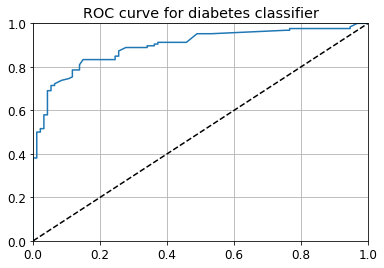

In [443]:
cat_train_pred = cat_model_3.predict(x_train)
cat_train_acc = np.sqrt(accuracy_score(y_train, cat_train_pred))
print('훈련 정확도 : {:.4f}'.format(cat_train_acc))


preds = cat_model_3.predict(x_test)
cat_test_acc = np.sqrt(accuracy_score(y_test, preds))
print("예측 정확도 : {:.4f}".format(cat_test_acc))
print(" < Confusion Matrix > \n {}".format(confusion_matrix(y_test , preds)))

preds_prob = cat_model_3.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, preds_prob[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# 결과 요약표를 만들기 위해 Dict 형태로 저장
models_result_base_3["CatBoostClassifier_train"] = round(cat_train_acc,4)
models_result_base_3["CatBoostClassifier_test"] = round(cat_test_acc, 4)

### 변수 중요도 확인

In [444]:
feature_importance_df = pd.DataFrame.from_dict(dict(zip(cat_model_3.feature_names_,
                                                        cat_model_3.feature_importances_)),orient="index",columns=["feature_value"]) 


feature_importance_df.sort_values(by=["feature_value"],ascending=False)

,feature_value
Sex,43.129281
Pclass,23.619984
Age_range,12.742939
SibSp_Parch,8.236552
Fare_range,6.235561
Embarked,6.035683


### 예측 결과 요약

In [445]:
final_results = pd.DataFrame([models_result_base_1,
                              models_result_base_2,
                              models_result_base_3],                             
                            index=['models_result_base_1',
                                   'models_result_base_2',
                                   'models_result_base_3'])

final_results.transpose()

,models_result_base_1,models_result_base_2,models_result_base_3
LogisticRegression_Train,0.7974,0.8227,0.8063
LogisticRegression_test,0.7753,0.7921,0.7864
RandomForestClassifier_Train,0.8086,0.8326,0.8200
RandomForestClassifier_test,0.7921,0.7921,0.8227
DecisionTreeClassifier_Train,0.7678,0.8073,0.8257
DecisionTreeClassifier_test,0.7865,0.7865,0.8091
CatBoostClassifier_train,0.9202,0.9209,0.9156
CatBoostClassifier_test,0.8900,0.8900,0.9070
